https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [6]:
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")
IDtest = test["PassengerId"]

In [29]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)    # ->한 피쳐에 이상값 몇갠지 count. 
    #이 부분이 어려운데, (각 관측치별로 (index, 이상치 개수) 구조임) 
    #n개 이상의 이상치면 추가
    multiple_outliers = list( k for k,v in outlier_indices.items() if v > n )
    #print(outlier_indices.items())
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"]) # 수치형 변수들
#print(Outliers_to_drop)

In [30]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [35]:
train = train.drop(Outliers_to_drop , axis=0).reset_index(drop=True)

In [36]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [38]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [39]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [40]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


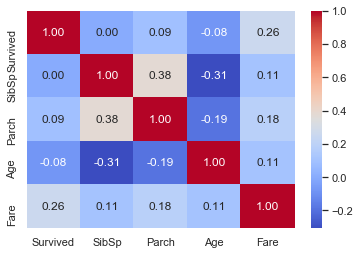

In [42]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

D:\Hyun\Daejjyu\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
D:\Hyun\Daejjyu\anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


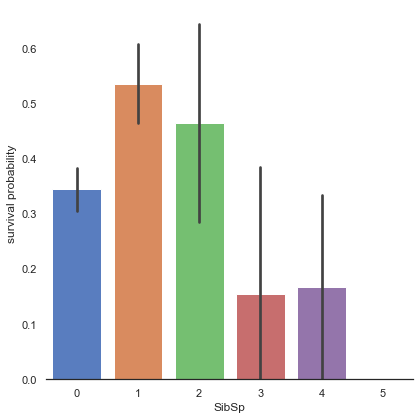

In [46]:
g =sns.factorplot(x='SibSp',y='Survived',data=train,kind="bar",size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels("survival probability")

D:\Hyun\Daejjyu\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
D:\Hyun\Daejjyu\anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


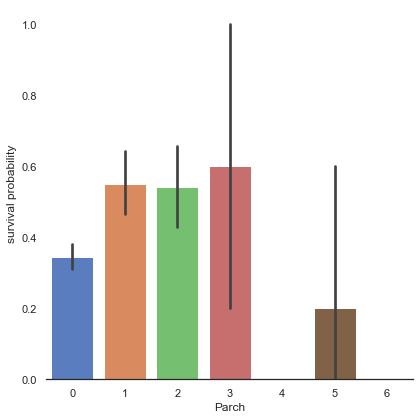

In [47]:
g = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar",size=6,palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

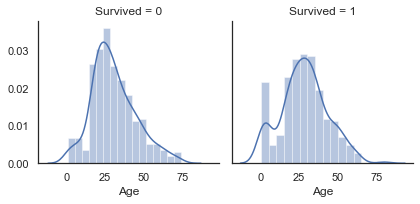

In [51]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

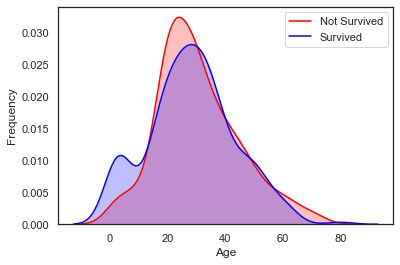

In [52]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [53]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

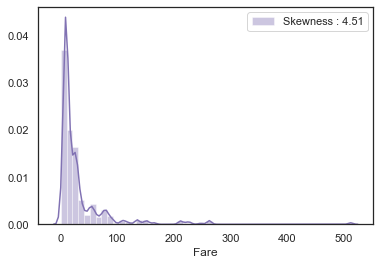

In [54]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [55]:
dataset["Fare"] =dataset["Fare"].map(lambda i: np.log(i) if i>0 else 0)

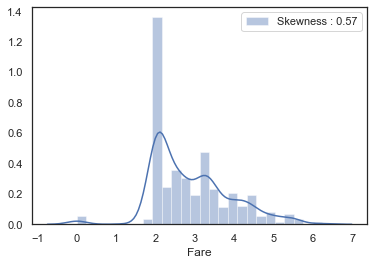

In [56]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

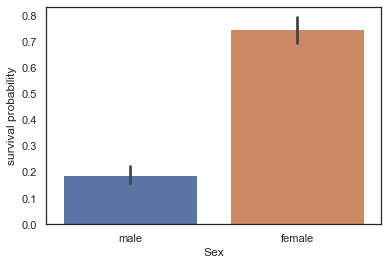

In [57]:
g=sns.barplot(x="Sex",y="Survived",data=train)
g= g.set_ylabel("survival probability")

In [58]:
train[["Sex","Survived"]].groupby('Sex').mean()


,Survived
Sex,
female,0.747573
male,0.190559


D:\Hyun\Daejjyu\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
D:\Hyun\Daejjyu\anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


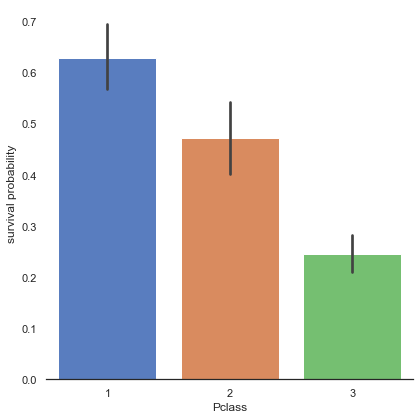

In [63]:
g= sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar",size=6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

D:\Hyun\Daejjyu\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
D:\Hyun\Daejjyu\anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


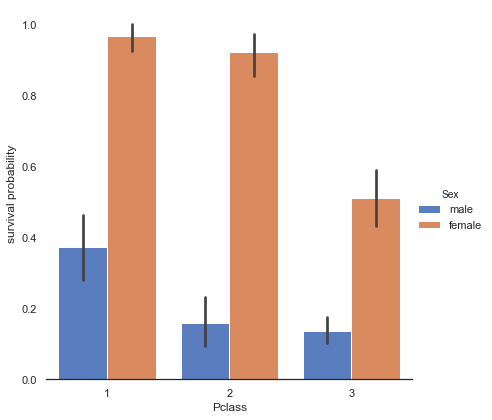

In [64]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")